In [1]:
using Images
using PyPlot
using Printf
using Random
using Statistics
using LinearAlgebra
using Interpolations
using PyPlot

include("Common.jl")

Main.Common

In [2]:
#---------------------------------------------------------
# Loads keypoints from JLD2 container.
#
# INPUTS:
#   filename     JLD2 container filename
#
# OUTPUTS:
#   keypoints1   [n x 2] keypoint locations (of left image)
#   keypoints2   [n x 2] keypoint locations (of right image)
#
#---------------------------------------------------------
function loadkeypoints(filename::String)
  # Load File 
  data = load(filename);
  # extract keypoints
  keypoints1 = data["keypoints1"];
  keypoints2 = data["keypoints2"];
  @assert size(keypoints1,2) == 2
  @assert size(keypoints2,2) == 2
  return keypoints1::Array{Int64,2}, keypoints2::Array{Int64,2}
end
    


loadkeypoints (generic function with 1 method)

In [3]:
#---------------------------------------------------------
# Compute pairwise Euclidean square distance for all pairs.
#
# INPUTS:
#   features1     [128 x m] descriptors of first image
#   features2     [128 x n] descriptors of second image
#
# OUTPUTS:
#   D             [m x n] distance matrix
#
#---------------------------------------------------------
function euclideansquaredist(features1::Array{Float64,2},features2::Array{Float64,2})
    # Calculate ESD via (a^2 - b^2 ) = b^2 + a^2 -2*ab
    D = sum(features1.^2, dims=1)'.+ sum(features2.^2, dims=1)-2*features1' * features2
 
    @assert size(D) == (size(features1,2),size(features2,2))
  return D::Array{Float64,2}
end

euclideansquaredist (generic function with 1 method)

In [4]:
#---------------------------------------------------------
# Find pairs of corresponding interest points given the
# distance matrix.
#
# INPUTS:
#   p1      [m x 2] keypoint coordinates in first image.
#   p2      [n x 2] keypoint coordinates in second image.
#   D       [m x n] distance matrix
#
# OUTPUTS:
#   pairs   [min(N,M) x 4] vector s.t. each row holds
#           the coordinates of an interest point in p1 and p2.
#
#---------------------------------------------------------
function findmatches(p1::Array{Int,2},p2::Array{Int,2},D::Array{Float64,2})
    # Init Dimensions
    m = size(p1, 1)
    n = size(p2, 1)
    # Init Array for pairs
    if m <= n
        p_sm = p1
        p_la = p2
    else
        p_sm = p2
        p_la = p1
        D = D'
    end
    # Add Pairs
    pairs = zeros(Int, size(p_sm, 1), 4)
    for i in 1:size(p_sm, 1)
        pairs[i,:] = [p_sm[i,:] p_la[argmin(D[i,:]),:]]
    end

  @assert size(pairs) == (min(size(p1,1),size(p2,1)),4)
  return pairs::Array{Int,2}
end

findmatches (generic function with 1 method)

In [5]:
#---------------------------------------------------------
# Show given matches on top of the images in a single figure.
# Concatenate the images into a single array.
#
# INPUTS:
#   im1     first grayscale image
#   im2     second grayscale image
#   pairs   [n x 4] vector of coordinates containing the
#           matching pairs.
#
#---------------------------------------------------------
function showmatches(im1::Array{Float64,2},im2::Array{Float64,2},pairs::Array{Int,2})
    figure()
    imshow([im1 im2], "gray", interpolation="none")
    c = size(im1,2 )
    n = size(pairs, 1)
    for i= 1:n
        plot([pairs[i, 1], pairs[i, 3]+c], [pairs[i ,2], pairs[i,4]])
    end


  return nothing::Nothing
end

showmatches (generic function with 1 method)

In [6]:
#---------------------------------------------------------
# Computes the required number of iterations for RANSAC.
#
# INPUTS:
#   p    probability that any given correspondence is valid
#   k    number of samples drawn per iteration
#   z    total probability of success after all iterations
#
# OUTPUTS:
#   n   minimum number of required iterations
#
#---------------------------------------------------------
function computeransaciterations(p::Float64,k::Int,z::Float64)
    # Given Fomular
    n = Int(ceil(log(1-z) / log(1-p^k)))

  return n::Int
end

computeransaciterations (generic function with 1 method)

In [7]:
#---------------------------------------------------------
# Randomly select k corresponding point pairs.
#
# INPUTS:
#   points1    given points in first image
#   points2    given points in second image
#   k          number of pairs to select
#
# OUTPUTS:
#   sample1    selected [kx2] pair in left image
#   sample2    selected [kx2] pair in right image
#
#---------------------------------------------------------
function picksamples(points1::Array{Int,2},points2::Array{Int,2},k::Int)
    #Randomize Samples
    idx = randperm(size(points1,1))[1:k]
    #Add Samples
    sample1 = points1[idx,:]
    sample2 = points2[idx,:]


  @assert size(sample1) == (k,2)
  @assert size(sample2) == (k,2)
  return sample1::Array{Int,2},sample2::Array{Int,2}
end

picksamples (generic function with 1 method)

In [9]:
#---------------------------------------------------------
# Conditioning: Normalization of coordinates for numeric stability.
#
# INPUTS:
#   points    unnormalized coordinates
#
# OUTPUTS:
#   U         normalized (conditioned) coordinates
#   T         [3x3] transformation matrix that is used for
#                   conditioning
#
#---------------------------------------------------------
function condition(points::Array{Float64,2})
    # Squared Distance
    s = 0.5 * maximum(sqrt.(sum(points.^2, dims=2)))
    # Calc mean
    tx = mean(points[1,:])
    ty = mean(points[2,:])

    # Build Transformation matrix
    T = [1/s 0 -tx/s;
        0 1/s -ty/s;
        0 0 1]

   # 
    U = T * Common.cart2hom(points')
  
    U = collect(Common.hom2cart(U)')


  @assert size(U) == size(points)
  @assert size(T) == (3,3)
  return U::Array{Float64,2},T::Array{Float64,2}
end

condition (generic function with 1 method)

In [95]:
#---------------------------------------------------------
# Estimates the homography from the given correspondences.
#
# INPUTS:
#   points1    correspondences in left image
#   points2    correspondences in right image
#
# OUTPUTS:
#   H         [3x3] estimated homography
#
#---------------------------------------------------------
function computehomography(points1::Array{Int,2}, points2::Array{Int,2})
    # Condition 
    U1, T1 = condition(Float64.(points1))
    U2, T2 = condition(Float64.(points2))

    U1 = Common.cart2hom(U1')
    U2 = Common.cart2hom(U2')
    #collect koordinates
    x1 = U1[1,:]
    y1 = U1[2,:]
    x2 = U2[1,:]
    y2 = U2[2,:]
    
    # Build Homograpy-matrix
    O = zeros(size(x1,1))
    I = ones(size(x1,1))
    
    A = [ O O O x1 y1 I -x1.*y2 -y1.*y2 -y2;
         -x1 -y1 -I O O O x1.*x2 y1.*x2 x2 ] 

    _, _, V = svd(A, full=true)

    H = reshape(V[:,end], 3,3)'

    H = T2\ H * T1

  @assert size(H) == (3,3)
  return H::Array{Float64,2}
end


computehomography (generic function with 1 method)

In [109]:

#---------------------------------------------------------
# Computes distances for keypoints after transformation
# with the given homography.
#
# INPUTS:
#   H          [3x3] homography
#   points1    correspondences in left image
#   points2    correspondences in right image
#
# OUTPUTS:
#   d2         distance measure using the given homography
#
#---------------------------------------------------------
function computehomographydistance(H::Array{Float64,2},points1::Array{Int,2},points2::Array{Int,2})

    x1 = Common.cart2hom(points1')
    x2 = Common.cart2hom(points2')
    xt1 = Common.hom2cart(H * x1)
    xt2 = Common.hom2cart(H \ x2)
    # Calculate distance between the coordinates
    d2 = sum((( xt1 - points2').^2 + (points1' - xt2).^2)', dims=2)
    
  @assert length(d2) == size(points1,1)
  return d2::Array{Float64,2}
end


computehomographydistance (generic function with 1 method)

In [12]:
#---------------------------------------------------------
# Compute the inliers for a given distances and threshold.
#
# INPUTS:
#   distance   homography distances
#   thresh     threshold to decide whether a distance is an inlier
#
# OUTPUTS:
#  n          number of inliers
#  indices    indices (in distance) of inliers
#
#---------------------------------------------------------
function findinliers(distance::Array{Float64,2},thresh::Float64)
    # find indices that fit in the threshold
    indices = [i[1] for i in findall(distance .< thresh)]
    n = length(indices)
  return n::Int,indices::Array{Int,1}
end

findinliers (generic function with 1 method)

In [91]:
#---------------------------------------------------------
# RANSAC algorithm.
#
# INPUTS:
#   pairs     potential matches between interest points.
#   thresh    threshold to decide whether a homography distance is an inlier
#   n         maximum number of RANSAC iterations
#
# OUTPUTS:
#   bestinliers   [n x 1 ] indices of best inliers observed during RANSAC
#
#   bestpairs     [4x4] set of best pairs observed during RANSAC
#                 i.e. 4 x [x1 y1 x2 y2]
#
#   bestH         [3x3] best homography observed during RANSAC
#
#---------------------------------------------------------
function ransac(pairs::Array{Int,2},thresh::Float64,n::Int)
    # init pairs and best inliers 
    points1 = pairs[:,1:2]
    points2 = pairs[:,3:4]
    bestinliers = []
    bestpairs = [] 
    bestH = []
    
    
    for i=1:n
        #get samples
        sample1, sample2 = picksamples(points1, points2, 4)
        # compute homography
        H = computehomography(sample1, sample2)
        # avoid numerical problems 
        if det(H) == 0
            i -= 1
            continue
        end
        # calc distance between points
        d2 = computehomographydistance(H, points1, points2)
        ninlines, indices = findinliers(d2, thresh)
        # find efficient inlines
        if ninlines > length(bestinliers)
            bestinliers = indices
            bestpairs = [sample1 sample2]
            bestH = H
        end
    end
    
    

  @assert size(bestinliers,2) == 1
  @assert size(bestpairs) == (4,4)
  @assert size(bestH) == (3,3)
  return bestinliers::Array{Int,1},bestpairs::Array{Int,2},bestH::Array{Float64,2}
end


ransac (generic function with 1 method)

In [18]:

#---------------------------------------------------------
# Recompute the homography based on all inliers
#
# INPUTS:
#   pairs     pairs of keypoints
#   inliers   inlier indices.
#
# OUTPUTS:
#   H         refitted homography using the inliers
#
#---------------------------------------------------------
function refithomography(pairs::Array{Int64,2}, inliers::Array{Int64,1})
    # calculate fitting
    inliers1 = pairs[inliers,1:2]
    inliers2 = pairs[inliers,3:4]
    H = computehomography(inliers1, inliers2)

  @assert size(H) == (3,3)
  return H::Array{Float64,2}
end

refithomography (generic function with 1 method)

In [114]:
#---------------------------------------------------------
# Show panorama stitch of both images using the given homography.
#
# INPUTS:
#   im1     first grayscale image
#   im2     second grayscale image
#   H       [3x3] estimated homography between im1 and im2
#
#---------------------------------------------------------
function showstitch(im1::Array{Float64,2},im2::Array{Float64,2},H::Array{Float64,2})
    height, width = size(im1)
    im = [im1[:,1:300] zeros(height, 400)]

   
    im2_itp = interpolate(im2, BSpline(Linear()))

    
    for x in 1:size(im, 1)
        for y in 1:size(im, 2)
          
            idx = Common.hom2cart(H * Common.cart2hom([y; x]))
            if (1 <= idx[1] <= size(im2, 2)) && (1 <= idx[2] <= size(im2, 1))
                
                im[x,y] = im2_itp(idx[2], idx[1])
            end
        end
    end


    im[1:size(im1,1),1:300] = im1[:,1:300]

    PyPlot.figure()
    PyPlot.imshow(im, "gray")
    PyPlot.show()

  return nothing::Nothing
end

showstitch (generic function with 1 method)

In [147]:
#---------------------------------------------------------
# Problem 2: Image Stitching
#---------------------------------------------------------
function problem2()
  # SIFT Parameters
  sigma = 1.4             # standard deviation for presmoothing derivatives

  # RANSAC Parameters
  #0.005 and 500.0  stand=50
  # 3 * 0.005
  # 3 * 0.05
  # 3 * 0.5
  # 3 * 5
  # 3 * 50
  # 3 * 500
  ransac_threshold = 500.0 # inlier threshold
  p = 0.5                 # probability that any given correspondence is valid
  k = 4                   # number of samples drawn per iteration
  z = 0.99                # total probability of success after all iterations

  # load images
  im1 = PyPlot.imread("a3p2a.png")
  im2 = PyPlot.imread("a3p2b.png")

  # Convert to double precision
  im1 = Float64.(im1)
  im2 = Float64.(im2)

  # load keypoints
  keypoints1, keypoints2 = loadkeypoints("keypoints.jld2")

  # extract SIFT features for the keypoints
  features1 = Common.sift(keypoints1,im1,sigma)
  features2 = Common.sift(keypoints2,im2,sigma)

  # compute chi-square distance  matrix
  D = euclideansquaredist(features1,features2)

  # find matching pairs
  pairs = findmatches(keypoints1,keypoints2,D)

  # show matches
  showmatches(im1,im2,pairs)
  title("Putative Matching Pairs")

  # compute number of iterations for the RANSAC algorithm
  niterations = computeransaciterations(p,k,z)

  # apply RANSAC
  bestinliers,bestpairs,bestH = ransac(pairs,ransac_threshold,niterations)
  @printf(" # of bestinliers : %d", length(bestinliers))
  
  # show best matches
  showmatches(im1,im2,bestpairs)
  title("Best 4 Matches")

  # show all inliers
  showmatches(im1,im2,pairs[bestinliers,:])
  title("All Inliers")

  # stitch images and show the result
  showstitch(im1,im2,bestH)

  # recompute homography with all inliers
  H = refithomography(pairs,bestinliers)
  showstitch(im1,im2,H)

  return nothing::Nothing
end


problem2 (generic function with 1 method)

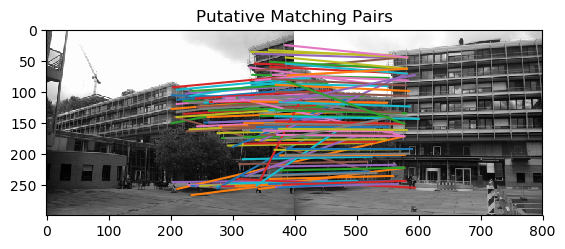

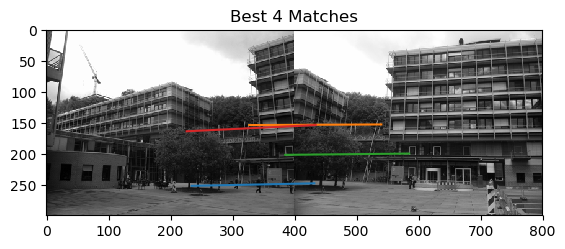

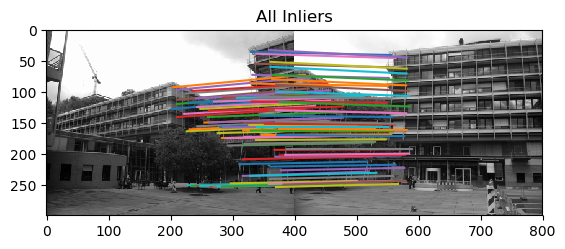

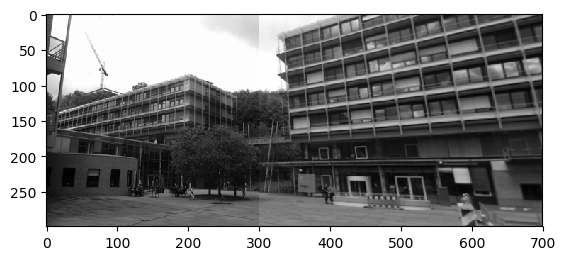

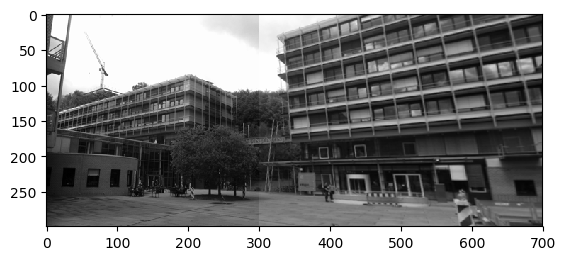

 # of bestinliers : 88

In [150]:
problem2()